In [4]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [5]:
all_data = loadmat('data/sample_1.mat')
keys = all_data.keys()
keys

dict_keys(['__header__', '__version__', '__globals__', 'samplingInterval', 'startData', 'chan', 'data', 'spike_times', 'spike_class'])

In [6]:
sample_data= all_data["data"]
sample_data.shape

(1, 2880000)

In [8]:
# Sampling rate of 32.051 kHz (32051 samples per second )
length_recording_sec = len(sample_data[0])/32051
length_recording_sec

89.85679073975851

In [9]:
# First look at the data
sample_data[0][:10]

array([  4.72638058,   4.26466759,   0.88346865,  -4.50652145,
        -6.56673384,  -4.74522643,  -4.88467592,  -7.50170421,
        -9.06807008, -10.42088687])

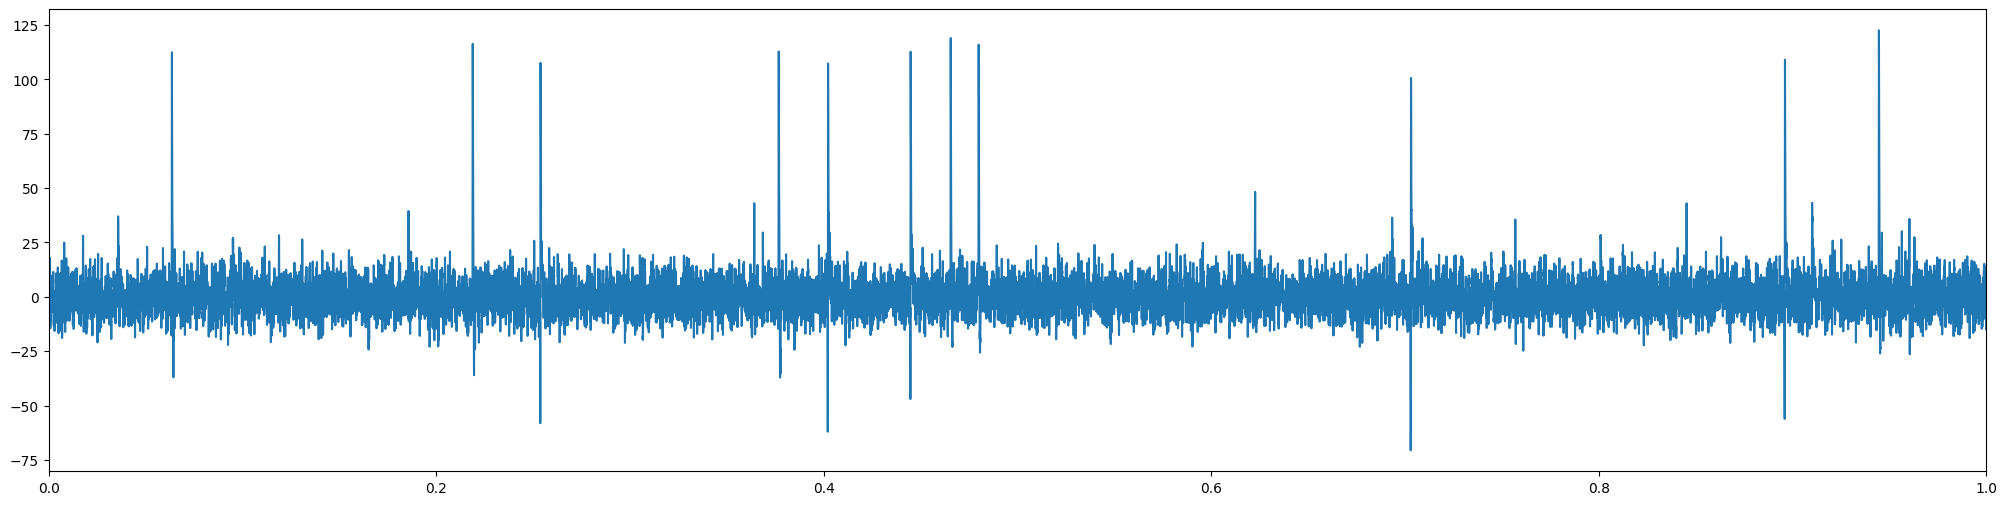

In [10]:
# Plot the data
seconds = 1
sr = 32051

data = sample_data[0][:round(seconds*sr)]
plt.figure(figsize=(25,6))
plt.plot(np.linspace(0, seconds, round(seconds*sr)), data)
plt.xlim(0, seconds)

plt.show()

In [11]:
# Filter Data by subtracting average
average_spike_value = np.sum(sample_data[0])/len(sample_data[0])
average_spike_value
# Does not seem  to make sense

np.float64(0.4507385876702088)

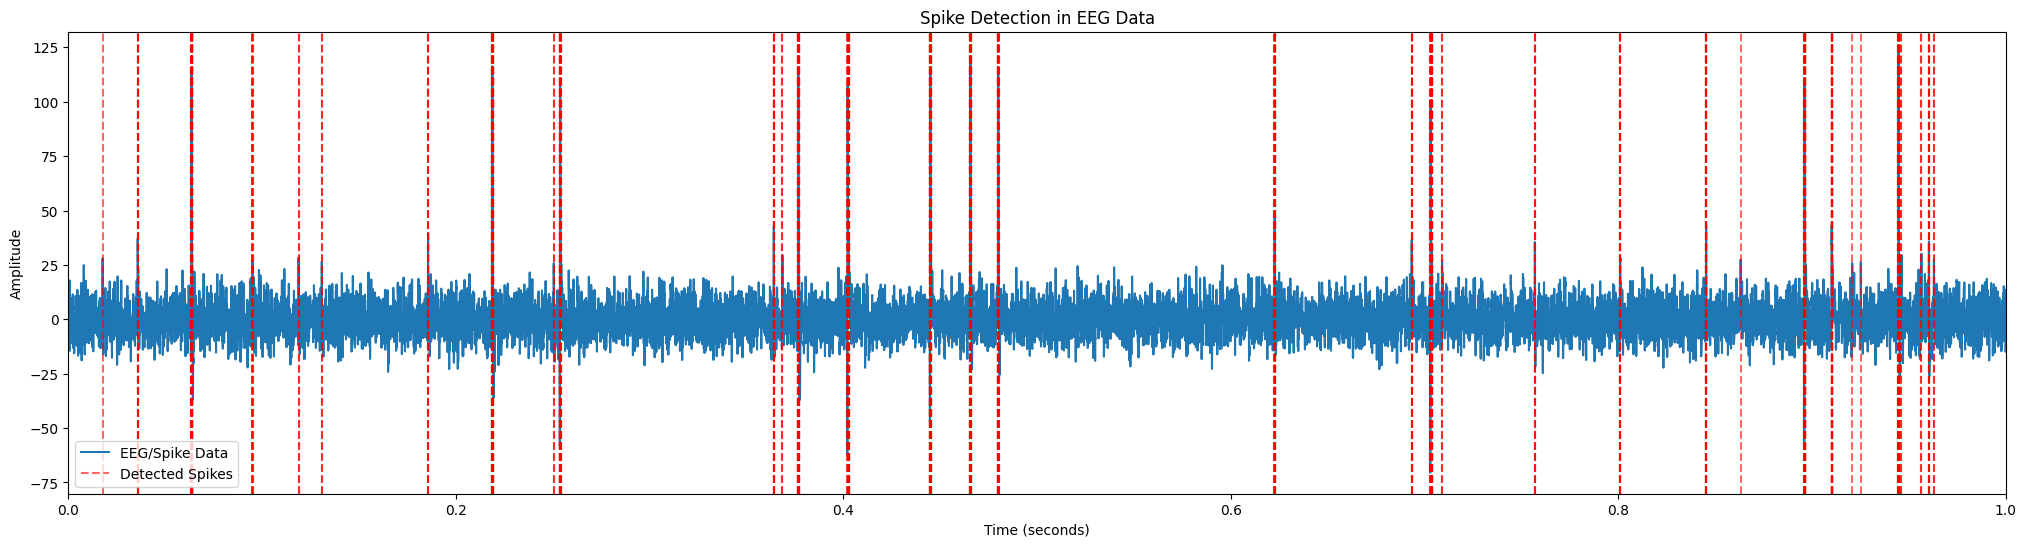

In [12]:
# Define the threshold for spike detection
threshold = 25

# Plot the raw data
plt.figure(figsize=(25, 6))
time = np.linspace(0, seconds, round(seconds * sr))
plt.plot(time, data, label='EEG/Spike Data')
plt.xlim(0, seconds)

# Detect spikes (where data exceeds the threshold)
spike_times = np.where(data > threshold)[0]  # Find the indices where data exceeds threshold

# Mark detected spikes with vertical lines
for spike in spike_times:
    plt.axvline(spike / sr, color='r', linestyle='--', alpha=0.6, label='Detected Spikes' if spike == spike_times[0] else "")

# Add labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Spike Detection in EEG Data')
plt.legend()

plt.show()